In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import nibabel as nib
import json

In [3]:
def parse_date(s):
    y = s[:4]
    m = s[4:6]
    return f"{y}_{m}"

def parse_contrast(s):
    _, _,  bodypart, contrast, \
        sequence, acq_dim, acq_plane, \
        agent, acq_num, *_ = s.split('-')
    return contrast

def parse_resolution_scale(fpath, eps=0.1):
    obj = nib.load(fpath)
    res = obj.header.get_zooms()
    scale = max(res) / min(res)
    if np.abs(scale - 1) < eps:
        return 1
    return scale

In [4]:
root_2021 = Path("/iacl/pg20/analysis/calabresi/")
root_2019 = Path("/iacl/pg20/calabresi/prevruns/calabresi2019/analyzed")

In [5]:
id_conversion_df = pd.read_csv(
    "/iacl/pg20/analysis/calabresi/calabresi-id-codebook.csv",
    names=["2019", "2021"]
)

In [6]:
patients_2019 = [x for x in root_2019.iterdir() if x.is_dir()]

In [7]:
def convert_2019_to_2021(id_2019, conversion_df):
    series = conversion_df[conversion_df["2019"] == id_2019]
    if len(series) == 0:
        return []
    
    id_2021 = list(series.iterrows())[-1][1]["2021"]
    return "CALABRESI-" + id_2021

In [8]:
def get_exam_date(path_2019):
    # grab any info file
    info_file = [x for x in (path_2019 / "raw").iterdir() 
                 if (".info" in x.suffixes)]
    if len(info_file) == 0:
        return 'xxxxxx'
    info_file = info_file[0]
    with open(info_file, 'r') as f:
        json_data = json.load(f)
        exam_date = json_data['exam_date']
    return exam_date

# Complete mapping of 2019 -> 2021

This mapping will be useful for future comparisons (if even needed).
Currently some issues prevent a complete mapping (see email chain with Blake), but this is not necessary to calculate numbers for the 11 June 2021 MRI in MS meeting

In [11]:
errors = []
prev_processed = []
for patient_2019 in patients_2019:
    patient_id = patient_2019.name
    patient_id_2021 = convert_2019_to_2021(int(patient_id), id_conversion_df)
    
    # get exam date for this session
    patient_2019_subdirs = [x for x in patient_2019.iterdir()
                            if x.name not in ["longitudinal", "qa_report"]]
    for session in patient_2019_subdirs:
        exam_date = get_exam_date(session)
        
        patient_2021 = root_2021 / patient_id_2021 / exam_date
        
        if not patient_2021.exists():
            errors.append((patient_id, session.name, patient_id_2021, exam_date))
        else:
            prev_processed.append(patient_id_2021 + "_" + exam_date)

In [13]:
sorted(prev_processed)

['CALABRESI-R01-HOCT3000_20180522',
 'CALABRESI-R01-MOCT0001_20050628',
 'CALABRESI-R01-MOCT0001_20050930',
 'CALABRESI-R01-MOCT0001_20060113',
 'CALABRESI-R01-MOCT0001_20060424',
 'CALABRESI-R01-MOCT0001_20060711',
 'CALABRESI-R01-MOCT0001_20070131',
 'CALABRESI-R01-MOCT0001_20070703',
 'CALABRESI-R01-MOCT0001_20081209',
 'CALABRESI-R01-MOCT0001_20100309',
 'CALABRESI-R01-MOCT0001_20110221',
 'CALABRESI-R01-MOCT0001_20120209',
 'CALABRESI-R01-MOCT0001_20130211',
 'CALABRESI-R01-MOCT0001_20140127',
 'CALABRESI-R01-MOCT0001_20141209',
 'CALABRESI-R01-MOCT0001_20160204',
 'CALABRESI-R01-MOCT0001_20170206',
 'CALABRESI-R01-MOCT0001_20170309',
 'CALABRESI-R01-MOCT0001_20180504',
 'CALABRESI-R01-MOCT0003_20050927',
 'CALABRESI-R01-MOCT0003_20060403',
 'CALABRESI-R01-MOCT0003_20070306',
 'CALABRESI-R01-MOCT0003_20080505',
 'CALABRESI-R01-MOCT0003_20090602',
 'CALABRESI-R01-MOCT0003_20100615',
 'CALABRESI-R01-MOCT0003_20110524',
 'CALABRESI-R01-MOCT0003_20120419',
 'CALABRESI-R01-MOCT0003_201

In [274]:
errors

[('20018', '09', 'CALABRESI-R01-MOCT0276', 'xxxxxx'),
 ('20204', '04', 'CALABRESI-R01-MOCT0820', '20110418'),
 ('20252', '06', 'CALABRESI-R01-MOCT1274', 'xxxxxx'),
 ('20258', '03', 'CALABRESI-R01-MOCT2127', 'xxxxxx'),
 ('21205', '07', 'CALABRESI-R01-MOCT0538', '20141222'),
 ('21212', '04', 'CALABRESI-R01-MOCT1360', '20120510'),
 ('21212', '06', 'CALABRESI-R01-MOCT1360', '20140923'),
 ('22203', '04', 'CALABRESI-R01-MOCT1419', '20120924'),
 ('22208', '05', 'CALABRESI-R01-MOCT1373', '20130305')]

# Count what was processed in 2019

In [46]:
# year range
year_min_2019 = 2030
year_max_2019 = 0

# number of T2STAR
num_t2_star = 0

# total number of subjects
num_2019_subjs = len([x for x in root_2019.iterdir() if x.is_dir()])

# total number of sessions
num_2019_sessions = 0
for subj_dir in [x for x in root_2019.iterdir() if x.is_dir()]:
    
    session_dirs = [x for x in subj_dir.iterdir() if x.is_dir()]
    
    num_2019_sessions += len(session_dirs)
    
    # year range
    for session_dir in [x for x in session_dirs if x.is_dir()
                       if x.name not in ["longitudinal", "qa_report"]]:
        exam_date = get_exam_date(session_dir)
        # skip unparsable exam dates
        if 'xx' in exam_date:
            continue
        year = int(exam_date[:4])
        
        if year < year_min_2019:
            year_min_2019 = year
        if year > year_max_2019:
            year_max_2019 = year
        
        # total number of T2STAR
        num_t2_star += len(
            [x for x in session_dir.iterdir() 
                 if "T2STAR_EPI_SAGITTAL_3D_POST" in x.name
                 and "reg" in x.name
                 and ".nii" in x.suffixes]
        )

In [47]:
num_2019_subjs

102

In [48]:
num_2019_sessions

998

In [49]:
year_min_2019, year_max_2019

(2005, 2019)

In [50]:
num_t2_star

87

# Count what will be processed in 2021

In [321]:
list((list([x for x in root_2021.iterdir() if x.is_dir()][0].iterdir())[0] / "nii").iterdir())

[PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20050930/nii/CALABRESI-R01-MOCT0001_20050930_BRAIN-DIFF-EPI-2D-AXIAL-PRE-ACQ1.nii.gz'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20050930/nii/CALABRESI-R01-MOCT0001_20050930_BRAIN-DIFF-EPI-2D-AXIAL-PRE-ACQ1.json'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20050930/nii/CALABRESI-R01-MOCT0001_20050930_BRAIN-DIFF-EPI-2D-AXIAL-PRE-ACQ2.nii.gz'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20050930/nii/CALABRESI-R01-MOCT0001_20050930_BRAIN-DIFF-EPI-2D-AXIAL-PRE-ACQ2.json'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20050930/nii/CALABRESI-R01-MOCT0001_20050930_BRAIN-MT-EPI-3D-AXIAL-PRE-ACQ1.nii.gz'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20050930/nii/CALABRESI-R01-MOCT0001_20050930_BRAIN-MT-EPI-3D-AXIAL-PRE-ACQ1.json'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20050930/nii/CALABRESI-R01-

In [73]:
subj_dirs = [x for x in root_2021.iterdir() if x.is_dir()]

In [74]:
subj_dir = subj_dirs[0]

In [75]:
session_dirs = [x for x in subj_dir.iterdir() if x.is_dir()
                   and (x / "nii").exists()]

In [76]:
session_dirs

[PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20050930'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20060113'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20060424'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20060711'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20070131'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20070703'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20081209'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20100309'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20110221'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20120209'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20130211'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20140127'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20141209'),

In [78]:
def contrast_filter(d):
    CONTRASTS = ["BRAIN-T2", "BRAIN-FLAIR", "BRAIN-PD"]
    niis = [x for x in d.iterdir() if ".nii" in x.suffixes]
    condition_1 = any("BRAIN-T1" in s.name and "3D" in s.name for s in niis)
    condition_2 = all(any(t in s.name for s in niis) for t in CONTRASTS)
    return condition_1 and condition_2
    
nii_dirs = [s/"nii" for s in session_dirs]
session_dirs = list(filter(contrast_filter, nii_dirs))

In [79]:
session_dirs

[PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20050930/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20060113/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20060424/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20060711/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20070131/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20070703/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20081209/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20100309/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20110221/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20120209/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20130211/nii'),
 PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT0001/20140127/nii'),
 PosixPath('/iacl/pg20/analy

In [94]:
# year range
year_min_2021 = 2030
year_max_2021 = 0

# number of T2STAR
num_t2_star = 0

# total number of subjects
num_2021_subjs = len([x for x in root_2021.iterdir() if x.is_dir()])

# total number of sessions
num_2021_sessions = 0
for subj_dir in [x for x in root_2021.iterdir() if x.is_dir()]:
    
    session_dirs = [x for x in subj_dir.iterdir() if x.is_dir()
                   and (x / "nii").exists()]
    
    # remove sessions which don't have the 4 main
    # structural contrasts
    
    def contrast_filter(d):
        CONTRASTS = ["BRAIN-T2", "BRAIN-FLAIR", "BRAIN-PD"]
        niis = [x for x in d.iterdir() if ".nii" in x.suffixes]
        condition_1 = any("BRAIN-T1" in s.name and "3D" in s.name for s in niis)
        condition_2 = all(any(t in s.name for s in niis) for t in CONTRASTS)
        return condition_1 and condition_2

    nii_dirs = [s/"nii" for s in session_dirs]
    session_dirs = list(filter(contrast_filter, nii_dirs))
        
    num_2021_sessions += len(session_dirs)
    
    # year range
    for session_dir in session_dirs:
        
        if not session_dir.exists():
            continue
        
        year = int(session_dir.parent.name[:4])
        
        if year < year_min_2021:
            year_min_2021 = year
        if year > year_max_2021:
            year_max_2021 = year
        
        # total number of T2STAR
        num_t2_star += len(
            [x for x in session_dir.iterdir() 
             if "BRAIN-T2STAR-EPI-3D-SAGITTAL-POST-ACQ1-MAG" in x.name
                and ".nii" in x.suffixes
            ]
        )

In [95]:
year

2019

In [102]:
session_dir

PosixPath('/iacl/pg20/analysis/calabresi/CALABRESI-R01-MOCT1820/20190213/nii')

In [103]:
session_dirs

[]

In [97]:
num_2021_subjs

439

In [98]:
num_2021_sessions

1756

In [99]:
year_min_2021, year_max_2021

(2005, 2021)

In [100]:
num_t2_star

484

# Number of Sessions Per Subject

In [9]:
# y-axis: subject count
# x-axis: # sessions / subject

In [10]:
df = pd.DataFrame(columns=["subject", "num_sessions_per_subject", "Year"])

In [11]:
# accumulate data

modes = [
    (2019, root_2019),
    (2021, root_2021),
]

for year, root_year in modes:
    for subj_dir in [x for x in root_year.iterdir() if x.is_dir()]:

        session_dirs = [x for x in subj_dir.iterdir() if x.is_dir()]
        subject = subj_dir.name

        df = df.append(
            {
                "subject": subject,
                "num_sessions_per_subject": len(session_dirs),
                "Year": year,
            },
            ignore_index=True,
        )

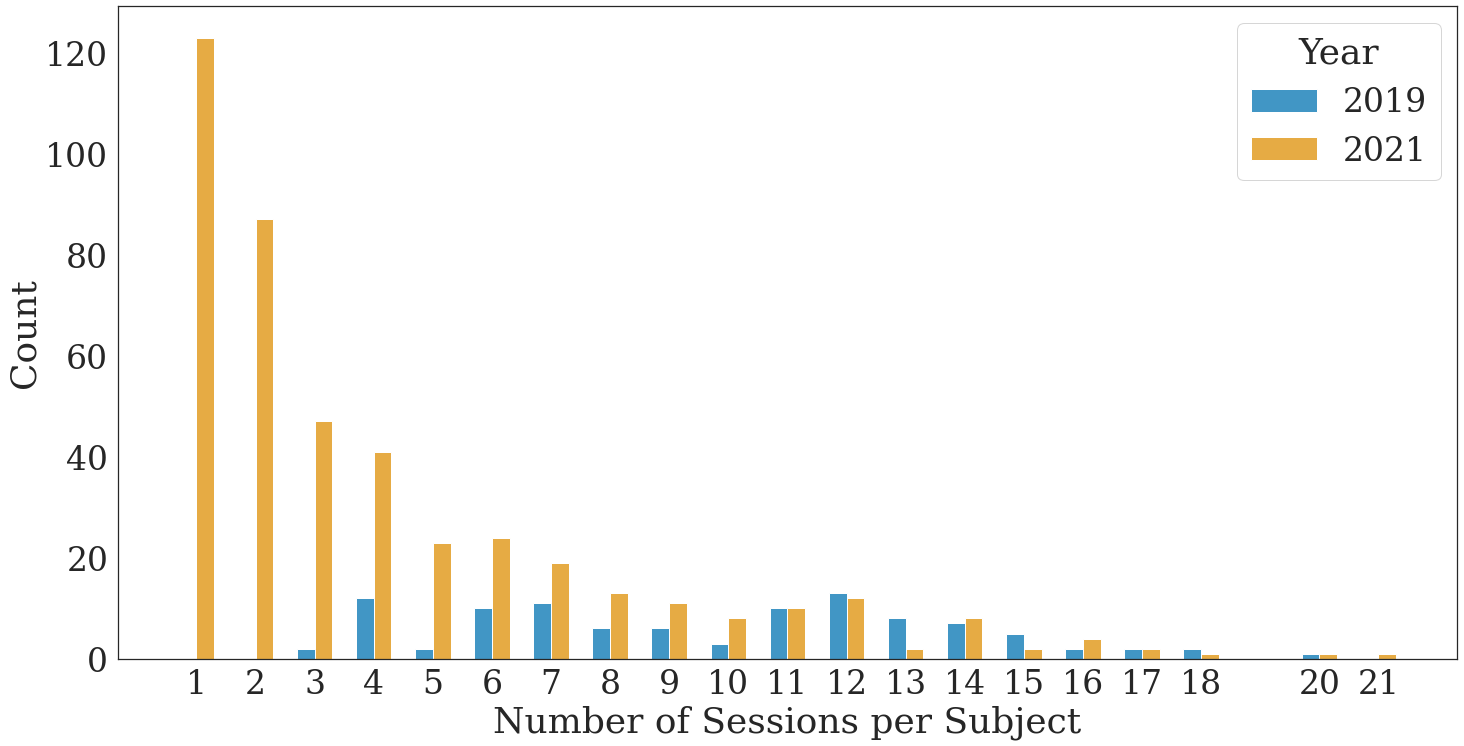

In [14]:
sns.set(
    font_scale=3, 
    style='white', 
    font='serif', 
    rc={"figure.figsize": (24, 12)}
)

ax = sns.histplot(
    x='num_sessions_per_subject', 
    data=df,
    hue='Year',
    bins=sorted((set(df['num_sessions_per_subject']))),
    discrete=True,
    multiple='dodge',
    palette=sns.color_palette("colorblind", 2),
    shrink=0.6
)

labels = sorted(set(df['num_sessions_per_subject']))
plt.xlabel("Number of Sessions per Subject")
plt.xticks(
    ticks=sorted(set(df['num_sessions_per_subject'])),
    labels=labels,
    rotation=0,
)
# plt.yscale('log')
ax.set
plt.show()

In [7]:
patients = [x for x in root_dir.iterdir() if x.is_dir()]

In [10]:
df = pd.DataFrame(columns=["year_month", "contrast"])

In [11]:
for patient in tqdm(patients):
    for time in patient.iterdir():
        nii_dir = time / "nii"
        if not nii_dir.exists():
            continue
        for f in nii_dir.iterdir():
            if '.nii' not in f.suffixes:
                continue
                
            contrast = parse_contrast(f.name)
            year_month = parse_date(time.name)
            
            df = df.append(
                {
                    "year_month": year_month,
                    "contrast": contrast,
                },
                ignore_index=True,
            )

100%|██████████| 392/392 [22:51<00:00,  3.50s/it] 


In [12]:
df.sort_values(by="year_month", axis="index", ascending=True, inplace=True)

In [6]:
df = pd.read_csv("data.csv")

In [7]:
df

Unnamed: 0 year_month contrast  resolution  resolution_buckets
0            3295    2005_04       T1    2.657005                 2.5
1            6495    2005_04       T1    2.658088                 2.5
2            6494    2005_04       T1    2.658088                 2.5
3            6493    2005_04       T1    2.658088                 2.5
4            3107    2005_04       PD    5.313255                 5.5
...           ...        ...      ...         ...                 ...
16093       12870    2020_03   T2STAR    1.000000                 1.0
16094       12871    2020_03       PD    3.490907                 3.5
16095       12872    2020_03       T2    3.490907                 3.5
16096       14896    2020_03       T1    1.000000                 1.0
16097       14977    2020_03       T1    1.000000                 1.0

[16098 rows x 5 columns]

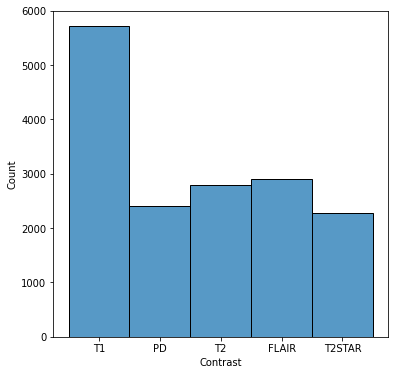

In [12]:
fig = plt.figure(figsize=(6, 6), facecolor='white')
ax = sns.histplot(x='contrast', data=df)
plt.xlabel("Contrast")
plt.show()

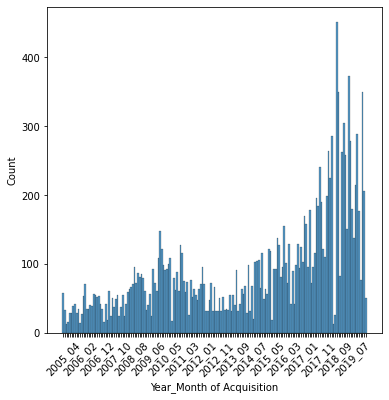

In [13]:
fig = plt.figure(figsize=(6, 6), facecolor='white')
ax = sns.histplot(x='year_month', data=df)
labels = [x if i%10 == 0 else '' for i, x in enumerate(sorted(set(df['year_month'])))]
plt.xticks(
    ticks=np.arange(len(set(df['year_month']))),
    labels=labels,
    rotation=45,
)
plt.xlabel("Year_Month of Acquisition")
plt.show()

In [24]:
set(df['contrast'])

{'FLAIR', 'PD', 'T1', 'T2', 'T2STAR'}

In [39]:
def round_nearest_half(n):
    if n == 1:
        return 1
    
    a = np.ceil(n)
    b = np.floor(n)
    c = np.floor(n) + 0.5
    
    eps_a = np.abs(n - a)
    eps_b = np.abs(n - b)
    eps_c = np.abs(n - c)
    
    if eps_a < eps_b and eps_a < eps_c:
        return a
    elif eps_b < eps_a and eps_b < eps_c:
        return b
    else:
        return c

In [40]:
# bucket the resolutions
df['resolution_buckets'] = df['resolution'].map(round_nearest_half)

In [16]:
df.sort_values(by="resolution_buckets", axis="index", ascending=True, inplace=True)

In [41]:
df.to_csv("data.csv")

In [17]:
df['resolution_buckets']

16097        1.0
10716        1.0
10717        1.0
10718        1.0
10719        1.0
          ...   
11612     1914.5
11613     5769.5
11611     5769.5
11610     9671.0
11609    30270.5
Name: resolution_buckets, Length: 16098, dtype: float64

In [18]:
set(df['resolution_buckets'])

{1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.5,
 7.0,
 9.0,
 10.0,
 11.5,
 12.0,
 12.5,
 13.5,
 15.0,
 1914.5,
 5769.5,
 9671.0,
 30270.5}

In [22]:
df[df['resolution_buckets'] > 10]

Unnamed: 0 year_month contrast    resolution  resolution_buckets
5675         4952    2013_11       PD     11.433935                11.5
3521        10436    2010_09       PD     11.433447                11.5
5541         7623    2013_08       PD     11.433447                11.5
2730          391    2010_01       PD     11.433446                11.5
3539        10271    2010_10       PD     11.432980                11.5
...           ...        ...      ...           ...                 ...
11612       15532    2018_07       PD   1914.577148              1914.5
11613       15533    2018_07       PD   5769.496582              5769.5
11611       15531    2018_07       PD   5769.496582              5769.5
11610       15530    2018_07       PD   9671.111328              9671.0
11609       15529    2018_07       PD  30270.531250             30270.5

[1561 rows x 5 columns]

In [23]:
df.drop?

In [20]:
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax = sns.histplot(x='resolution_buckets', data=df.drop())
plt.xlabel("Resolution Scale")
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f34d2d25430> (for post_execute):


KeyboardInterrupt: 